In [26]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Functions

In [2]:
##########################################################################################################
############## General Bag of Words Model functions ######################################################
##########################################################################################################

# Takes in two course names, the name of the column that holds the names, the dataframe, and the similarity matrix
# and returns their cosine similarity
def get_similarity(name1, name2, col_name, df, matrix):
    idx_1 = df[df[col_name] == name1].index
    idx_1 = idx_1[0]
    idx_2 = df[df[col_name] == name2].index
    idx_2 = idx_2[0]
    return matrix[idx_1, idx_2]

# Gets the course's cleaned description that is used to vectorize it
def get_clean_desc(df, course_name):
    idx_1 = df[df['department'] == course_name].index
    idx_1 = idx_1[0]
    return df.iloc[idx_1]['cleaned_description']

# Gets the course's regular description that is used to vectorize it
def get_reg_desc(df, course_name):
    idx_1 = df[df['course'] == course_name].index
    idx_1 = idx_1[0]
    return df.iloc[idx_1]['description_x']



#####################################################################################################
################ General Similarty Data and Visualization Tools #####################################
#####################################################################################################

def common_words(str1, str2, n):
    # Splitting the strings into words
    words_str1 = str1.split()
    words_str2 = str2.split()

    # Creating a dictionary to count the occurrences of each word in both strings
    word_count = {}
    for word in words_str1:
        if word in words_str2:
            word_count[word] = min(words_str1.count(word), words_str2.count(word))

    # Sorting the dictionary by the frequency of the words
    sorted_word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

    return sorted_word_count[0:n]


# Return the n most similar departments
def get_related(name, df, deps,  matrix, n):
    n=n+1
    idx = df[df['department'] == name].index
    sims = matrix[idx]
    # Get indices of sorted elements
    sorted_indices = np.argsort(sims)
    # Get indices of top n largest elements
    top_n_indices = sorted_indices[0][-n:][::-1]
    top_n_deps = np.array(deps)[top_n_indices]
    top_n_deps = np.delete(top_n_deps, np.where(top_n_deps == name))
    return top_n_deps

def get_threshold(matrix, max_pairs):
    """
    Find the threshold for similarity scores in the matrix.

    :param matrix: A 2D numpy array containing similarity scores between classes.
    :param max_pairs: Maximum number of class pairs with similarity above the threshold.
    :return: Threshold value.
    """

    # Flatten the matrix to get all similarity scores
    scores = matrix[np.triu_indices_from(matrix, k=1)]  # k=1 to exclude the diagonal

    # Create bins for the range [0, 1]
    num_bins = 100
    bins = np.linspace(0, 1, num_bins + 1)
    
    # Count the number of scores in each bin
    counts, _ = np.histogram(scores, bins)

    # Find the cumulative count
    cumulative_counts = np.cumsum(counts[::-1])[::-1]

    # Find the bin where the cumulative count drops below the max_pairs
    threshold_index = np.where(cumulative_counts <= max_pairs)[0]

    if len(threshold_index) == 0:
        return 1  # Return 1 if no such threshold exists (i.e., all scores are too low)

    # Get the lower edge of the bin as the threshold
    threshold_bin = threshold_index[0]
    threshold = bins[threshold_bin]

    return threshold

# Generating dataframe of related departments
def dep_sim_analysis(df, matrix, dep_name):
    related_departments = get_related('ENVIRON', df, matrix, 10)
    word_df = pd.DataFrame()
    for dept in related_departments:
        word_df[dept] = common_words(get_clean_desc(df, dep_name), get_clean_desc(df, dept), 10)
    return word_df

# Loading embeddings dataset

In [31]:
import ast
# Load data
df = pd.read_pickle('embeddings.pkl')

# Groupby department

In [32]:
# Get the department of each course
df['department'] = df['course'].str.extract(r'([A-Z]+)')
# Groupby Operation
df = df.groupby('department')['embedding'].apply(np.sum).reset_index()

In [35]:
df['embedding'] = df['embedding'].apply(lambda x: normalize([x])[0])

In [36]:
df

,department,embedding
0,AAS,"[-0.007471468722095482, -0.015007437591309193,..."
1,ACC,"[-0.006716650609556021, -0.013041202318509464,..."
2,ADABRD,"[3.636273081997788e-05, -0.0033828538740718083..."
3,AERO,"[-0.005027363162603976, -0.012076861185646177,..."
4,AEROSP,"[-0.0039825493987399735, 7.653774690759282e-05..."
...,...,...
305,WGS,"[-0.014064112656916943, -0.010529331787006794,..."
306,WMBA,"[-0.009108205995515877, -0.014643514844982105,..."
307,WOMENSTD,"[-0.009101409058745659, -0.014184146481319285,..."
308,WRITING,"[-0.004427961877581703, 0.007824535475361959, ..."


## Example of generating networks

In [37]:
# Make similarity matrix
matrix = [vec for vec in df['embedding']]
# Compute cosine similarities
similarity_matrix = cosine_similarity(matrix)
#Find similar courses
deps = df['department'].tolist()

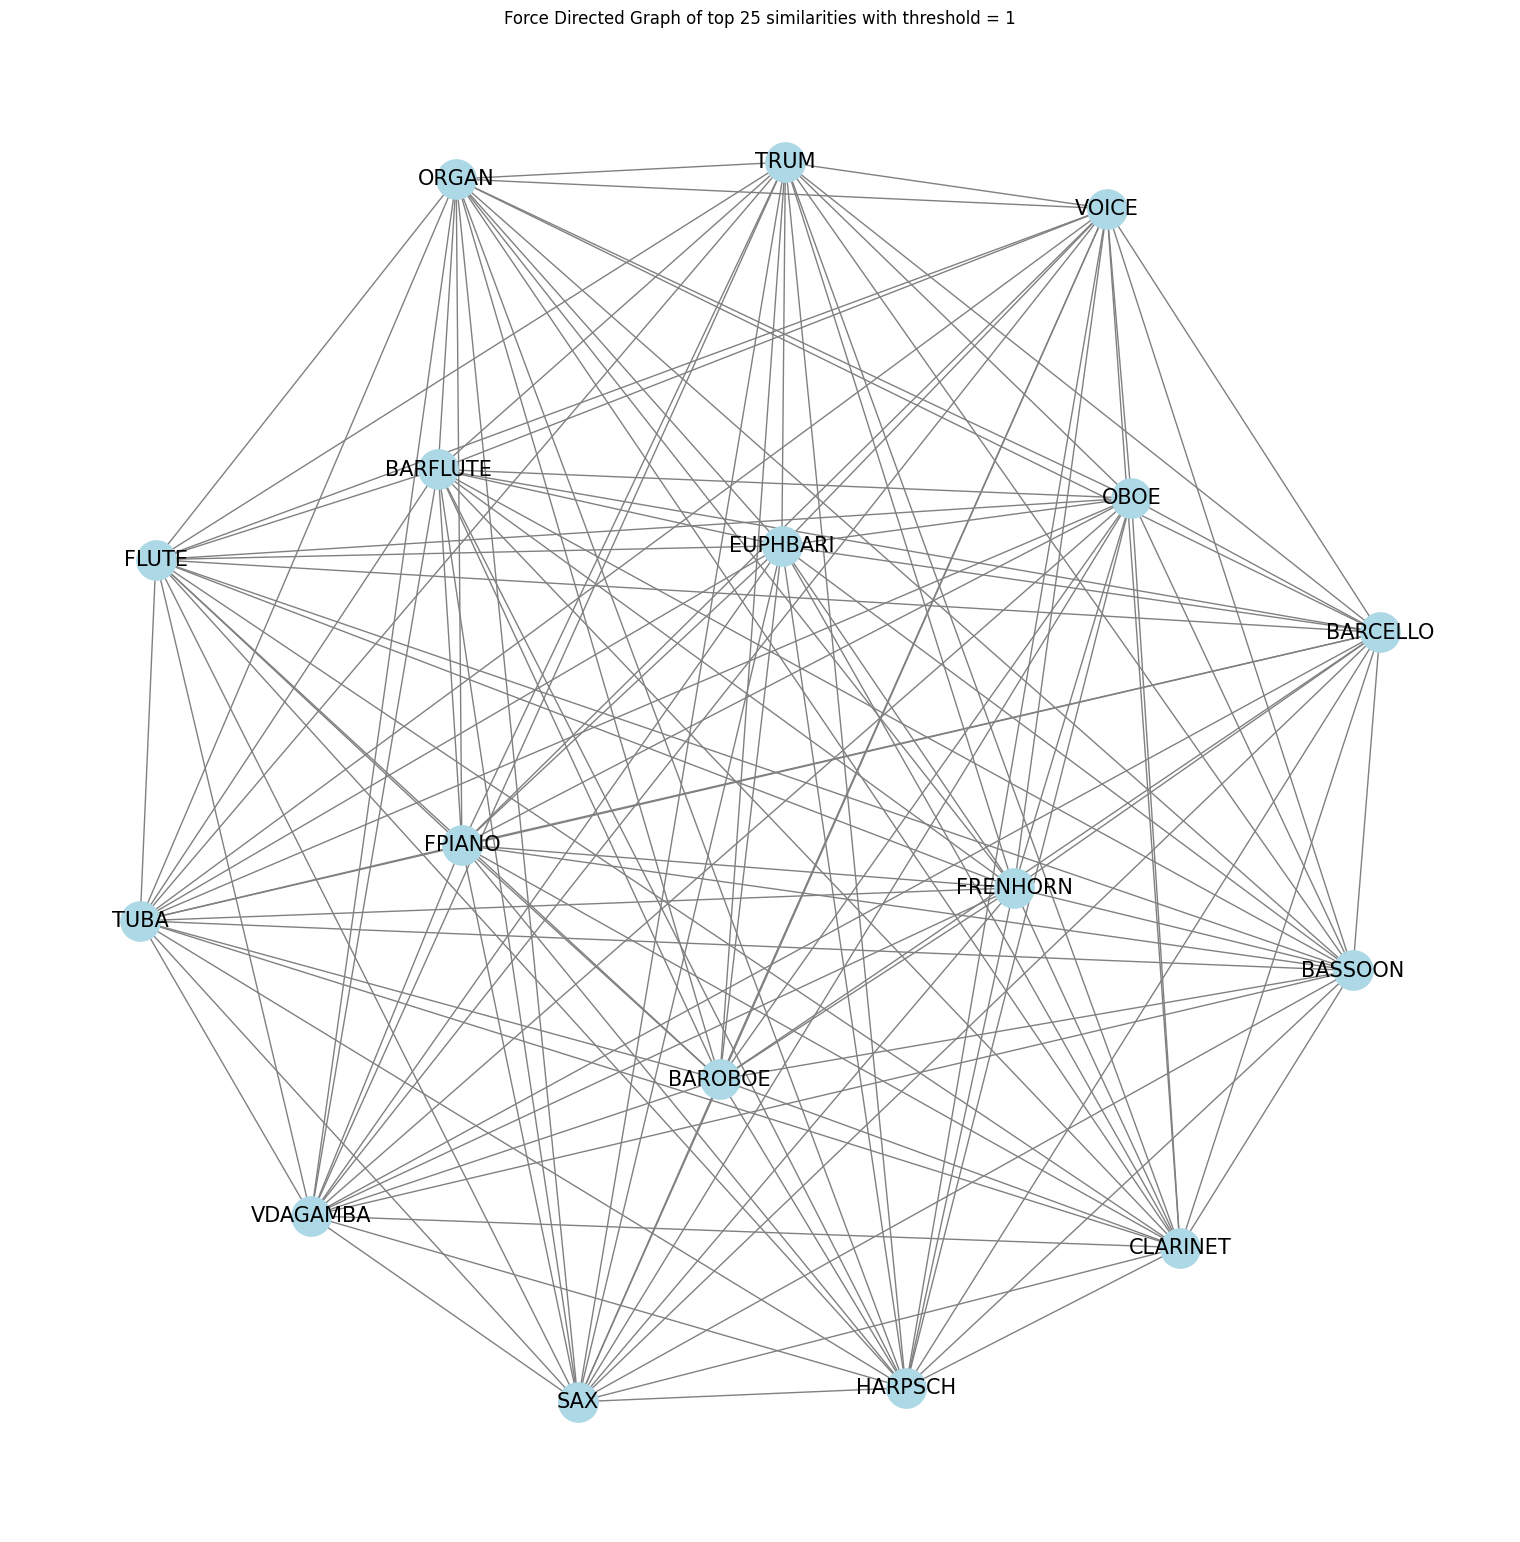

In [38]:
adjacency_matrix = similarity_matrix

# Create a graph
G = nx.Graph()

threshold = get_threshold(similarity_matrix, 25)

course_indices = set()
# Adding nodes and edges based on the adjacency matrix
for i in range(len(adjacency_matrix)):
    for j in range(i+1, len(adjacency_matrix)):
        # Add an edge between i and j with weight based on cosine similarity
        if similarity_matrix[i][j] > threshold:
            course_indices.add(i)
            course_indices.add(j)
            G.add_edge(deps[i], deps[j], weight=similarity_matrix[i][j])

# Generate positions for the nodes using a force-directed algorithm
positions = nx.spring_layout(G, weight='weight', k=0.7)

# Draw the graph
plt.figure(figsize=(15, 15))
nx.draw(G, positions, with_labels=True, node_color='lightblue', 
        node_size=800, edge_color='gray', linewidths=1, font_size=15)
plt.title(f"Force Directed Graph of top 25 similarities with threshold = {threshold}")
plt.show()

In [39]:
similarity_matrix

array([[1.        , 0.92658766, 0.94115529, ..., 0.94901374, 0.94841397,
        0.89064257],
       [0.92658766, 1.        , 0.94200259, ..., 0.89538525, 0.92507918,
        0.8392684 ],
       [0.94115529, 0.94200259, 1.        , ..., 0.8966996 , 0.92661431,
        0.85131613],
       ...,
       [0.94901374, 0.89538525, 0.8966996 , ..., 1.        , 0.93132195,
        0.86456929],
       [0.94841397, 0.92507918, 0.92661431, ..., 0.93132195, 1.        ,
        0.90203854],
       [0.89064257, 0.8392684 , 0.85131613, ..., 0.86456929, 0.90203854,
        1.        ]])

In [40]:
df.iloc[0]['embedding']

array([-0.00747147, -0.01500744,  0.008402  , ..., -0.01441855,
       -0.00711939, -0.01739262])

In [43]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Statistics of similarity distribution

In [51]:
np.fill_diagonal(similarity_matrix, np.nan)
upper_tri_indices = np.triu_indices_from(similarity_matrix, k=1)
similarities = similarity_matrix[upper_tri_indices]

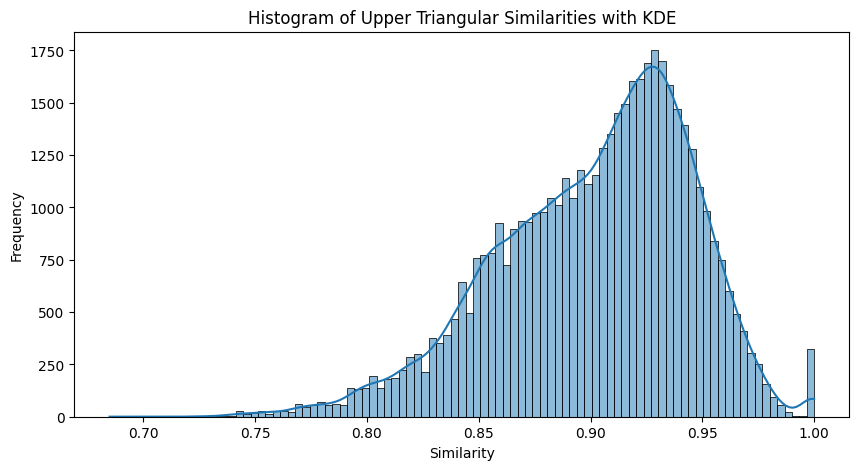

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(similarities, kde=True)
plt.title('Histogram of Upper Triangular Similarities with KDE')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

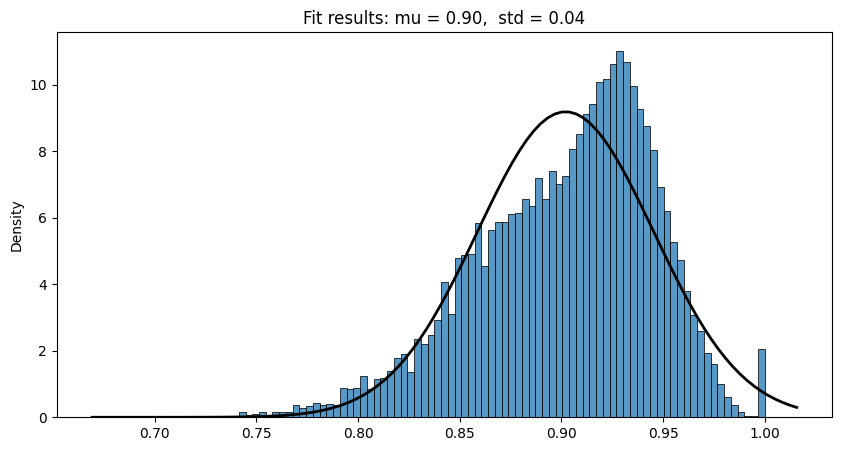

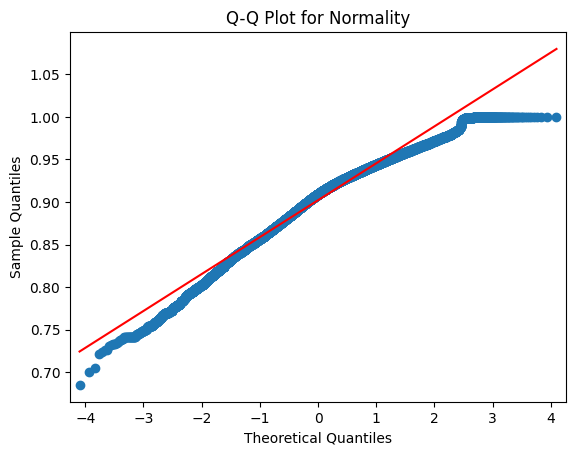

AIC for Normal: [-0.11730813  0.37465634 -0.36285862 ...  0.01786084  0.309648
 -0.43659592]
AIC for Exponential: [3.17129642 3.30548639 3.05395043 ... 3.21490638 2.6000131  2.94516176]
AIC for Uniform: [1.68999468 1.68999468 1.68999468 ... 1.68999468 1.68999468 1.68999468]


In [54]:
from scipy.stats import norm, expon, uniform
import statsmodels.api as sm

# Fit a normal distribution
mu, std = norm.fit(similarities)

# Plot the histogram and PDF of the fitted normal distribution
plt.figure(figsize=(10, 5))
sns.histplot(similarities, kde=False, stat="density")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()

# Q-Q plot for normality
sm.qqplot(similarities, line='s')
plt.title('Q-Q Plot for Normality')
plt.show()

# Fit other distributions if needed (e.g., exponential, uniform)
params_exp = expon.fit(similarities)
params_uniform = uniform.fit(similarities)

# Compare the fits using AIC or BIC
print('AIC for Normal:', sm.tools.eval_measures.aic(norm.logpdf(similarities, mu, std), similarities, len(params_exp)))
print('AIC for Exponential:', sm.tools.eval_measures.aic(expon.logpdf(similarities, *params_exp), similarities, len(params_exp)))
print('AIC for Uniform:', sm.tools.eval_measures.aic(uniform.logpdf(similarities, *params_uniform), similarities, len(params_uniform)))
